# N-Gram Language Model

## Part 1: Build an n-gram language model
Objective: Given a sentence, calculate its probability
### N-gram
P(“its water is so transparent”) =  P(its) × P(water|its) ×  P(is|its water) ×  P(so|its water is) ×  P(transparent|its water is so)
### Bigram
P(“its water is so transparent”) =  P(its) × P(water|its) ×  P(is|water) ×  P(so|is) ×  P(transparent|so)
### Trigram
P(“its water is so transparent”) =  P(its) × P(water|its) ×  P(is|its water) ×  P(so|water is) ×  P(transparent|is so)

- First Make a basic lookup table and n-1 gram count for each word against its context window

In [57]:
# Muhammad Huzaifa
# Roll No: 03-3-1-034-2022

corpus = open('transcript.txt', 'r').read()
training_sentences = corpus.split('\n')

# Set n-gram limit
n = 2 # bigram

### Vocabulary and N-Gram Count Generation

This code processes training sentences to build a vocabulary set, a lookup table for words, and an n-gram count dictionary:

1. **Initialize Data Structures**:
    - `vocabulary`: Unique words.
    - `words_lookup`: Word counts given context.
    - `ngram_count`: Context (n-1 gram) counts.

2. **Process Sentences**:
    - Split sentences into tokens, remove the first token (timestamp).
    - Update `vocabulary` with tokens.
    - For each word, update `ngram_count` and `words_lookup` based on the context window.

3. **Calculate Vocabulary Size**:
    - Compute and print the size of `vocabulary`.
    - Print `words_lookup`.



In [58]:
vocabulary = set()

words_lookup = {}
ngram_count = {}

for sentence in training_sentences:
    context_window = []
    training_tokens = sentence.split(' ')
    training_tokens.pop(0)         # Remove the timestamp token  
    vocabulary.update(training_tokens)

    for word in training_tokens:
        context_tuple = tuple(context_window)

        if (context_tuple not in ngram_count):
            ngram_count[context_tuple] = 0
        ngram_count[context_tuple] += 1
        if word not in words_lookup:
            words_lookup[word] = {}
        
        if context_tuple in words_lookup[word]:
            words_lookup[word][context_tuple] += 1
        else:
            words_lookup[word][context_tuple] = 1
        
        if len(context_window) == n - 1:
            context_window.pop(0)
        context_window.append(word)

vocabulary_size = len(vocabulary)

print(vocabulary_size)
print(words_lookup)

1994
{'okay': {(): 136, ('.',): 4, ('be',): 4, ('oh',): 2, ('is',): 13, ("it's",): 4, ('[lip_smack]',): 3, ("anything's",): 1, ('[laughter]',): 1, ('[loud_breath]',): 2, ('again',): 1, ('[um]',): 2}, "let's": {('okay',): 18, (): 213, ('.',): 5, ('[um]',): 2, ("<let's>",): 1, ('[lip_smack]',): 4, ('spend',): 1, ('walk',): 1, ('[uh]',): 6, ('[laughter]',): 3, ('said',): 1, ('[tap]',): 1, ('[unintelligible]',): 1, ('well',): 1, ('th-',): 1, ('so',): 3, ('',): 2, ('right',): 1, ('no',): 2, ('and',): 2}, 'see': {("let's",): 12, ('to',): 30, ('i',): 30, ('wanna',): 1, ('please',): 1, ('me',): 7, (): 1, ('cannot',): 1, ('you',): 1}, 'i': {('see',): 5, ('[uh]',): 56, (): 1922, ('and',): 46, ('so',): 25, ('but',): 18, ('[um]',): 25, ('<i>',): 3, ('<wanna>',): 1, ('cheap',): 3, ('where',): 23, ('think',): 12, ('vegetarian',): 1, ('if',): 17, ('can',): 152, ('[lip_smack]',): 55, ('far',): 2, ('since',): 1, ('.',): 46, ('actually',): 10, ('could',): 15, ('that',): 18, ('what',): 6, ('[loud_breath]

- **`get_probability(word, context)`**: Calculates the probability of a word given its context using add-one smoothing.
- For zero count words add smoothening (for now, we're using add 1 smoothing but Kneser-Ney Smoothing would be better choice if implemented)

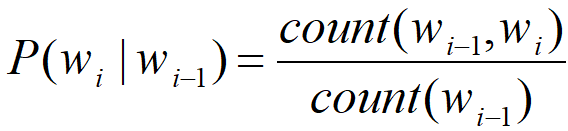

In [59]:
def get_probability(word: str, context: tuple):
    if word in words_lookup and context in words_lookup[word]:
        numerator = words_lookup[word].get(context, 0) + 1
    else:
        numerator = 1
    denominator = ngram_count.get(context, 0) + vocabulary_size
    return numerator / denominator

sentence = "okay we will have a dinner"

tokens = [token for token in sentence.split(' ') if token]

probability = 1.0
context_window = []

for word in tokens:
    context_tuple = tuple(context_window)
    
    probability *= get_probability(word, context_tuple)

    # slide context_window
    if len(context_window) == n - 1:
        context_window.pop(0)
    context_window.append(word)

print("The probability of given sentence is: " + str(probability))

The probability of given sentence is: 1.8243455474762827e-15


## Part 2: Implement Sentence Generation

- Now that we have our probability tables, we can now predict the probability of a given sentence
- **`predict_next_tokens(sentence, num_tokens)`**: Predicts the next `num_tokens` tokens for a given input sentence based on the n-gram model.

In [60]:
def predict_next_tokens(sentence, num_tokens=1):

    tokens = [token for token in sentence.split(' ') if token]
    context_window = tokens[-min(len(tokens), n-1):]
    
    predicted_tokens = []
    
    for _ in range(num_tokens):
        context_tuple = tuple(context_window)
        
        best_word = None
        best_prob = -1
        
        for word in vocabulary:
            prob = get_probability(word, context_tuple)
            if prob > best_prob:
                best_prob = prob
                best_word = word
        
        if best_word is None:
            break
            
        predicted_tokens.append(best_word)
        
        if len(context_window) == n - 1:
            context_window.pop(0)
        context_window.append(best_word)
    
    return predicted_tokens

input_sentence = "i will have to"
predictions = predict_next_tokens(input_sentence, 4)
print(f"Input: {input_sentence}")
print(f"Predicted next tokens: {' '.join(predictions)}")

Input: i will have to
Predicted next tokens: eat on saturday night


## Part 3: Create an out-of-domain test set and measure performance

In [61]:
from nltk.corpus import reuters
import re

def create_out_of_domain_corpus():
    # Get sentences from Reuters corpus as out-of-domain data
    sentences = []
    for fileid in reuters.fileids()[:50]:  # Limit to first 50 files
        text = reuters.raw(fileid)
        # Simple sentence splitting
        text_sentences = re.split(r'(?<=[.!?])\s+', text)
        sentences.extend(text_sentences[:5])  # Take first 5 sentences from each file

    # Clean sentences
    cleaned_sentences = []
    for s in sentences:
        s = s.strip()
        if len(s) > 10 and len(s.split()) >= 3:
            cleaned_sentences.append(s)

    return cleaned_sentences[:200]  # Return the first 200 sentences

out_domain_corpus = create_out_of_domain_corpus()
print(f"Created {len(out_domain_corpus)} out-of-domain test sentences")

Created 200 out-of-domain test sentences


```python
Calculate perplexity on test data

Args:
    test_sentences (list): List of test sentences
    
Returns:
    float: Perplexity score

In [62]:
def perplexity(test_sentences):
        log_prob_sum = 0.0
        token_count = 0
        
        for sentence in test_sentences:
            tokens = sentence.split()
            context = tuple(tokens[:n-1])
            
            for i in range(n-1, len(tokens)):
                word = tokens[i]
                prob = get_probability(word, context)
                log_prob_sum += np.log2(prob)
                context = context[1:] + (word,)
                token_count += 1
        
        # Calculate perplexity using 2^(-average log likelihood)
        return 2 ** (-log_prob_sum / token_count)


in_domain_perplexity = perplexity(training_sentences)
out_domain_perplexity = perplexity(out_domain_corpus)

print(f"In Domain Perplexity: {in_domain_perplexity:.2f}")
print(f"Out of Domain Perplexity: {out_domain_perplexity:.2f}")

In Domain Perplexity: 151.49
Out of Domain Perplexity: 1798.10
